In [1]:
# from matplot_util import *
import matplot_util

In [2]:
from hy3dgen.text2image import HunyuanDiTPipeline
import torch

import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from PIL import Image

In [3]:
external_model_path="/data/models/Hunyuan3D-2"

In [4]:
def showimg(img):
    plt.imshow(img)
    plt.show()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.pag.pipeline_pag_hunyuandit.HunyuanDiTPAGPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/25 [00:00<?, ?it/s]

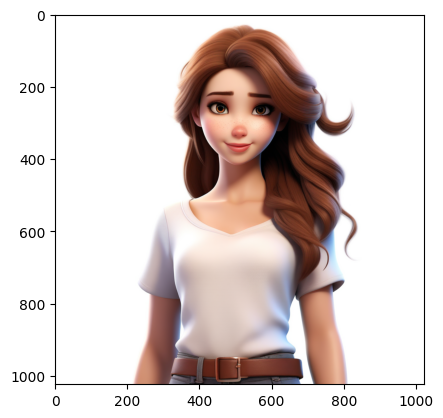

In [5]:
device = "cuda:3" if torch.cuda.is_available() else "cpu"
text2img_model = HunyuanDiTPipeline('Tencent-Hunyuan/HunyuanDiT-v1.1-Diffusers-Distilled', device=device)

image = text2img_model("a pretty girl")
# showimg(image)
# matplot_util.showimg(image)
plt.imshow(image)
plt.show()






In [7]:
import numpy as np
#去除背景
from hy3dgen.rembg import BackgroundRemover

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.

In [16]:
rembg = BackgroundRemover()
nobg_img = rembg(image=image)
nobg_img.save("girl.png")
showimg(nobg_img)

NameError: name 'BackgroundRemover' is not defined

In [8]:
from hy3dgen.shapegen import Hunyuan3DDiTFlowMatchingPipeline

In [ ]:
img2mesh_model = Hunyuan3DDiTFlowMatchingPipeline.from_pretrained(model_path=external_model_path,device=device)



In [10]:
from PIL import Image
from hy3dgen.texgen.differentiable_renderer.mesh_render import MeshRender
from hy3dgen.texgen.utils.dehighlight_utils import Light_Shadow_Remover
from hy3dgen.texgen.utils.imagesuper_utils import Image_Super_Net
from hy3dgen.texgen.utils.uv_warp_utils import mesh_uv_wrap
from hy3dgen.texgen.utils.multiview_utils import Multiview_Diffusion_Net
from hy3dgen.texgen import Hunyuan3DTexGenConfig


delight_model_path = "/data/models/Hunyuan3D-2/hunyuan3d-delight-v2-0"
multiview_model_path = "/data/models/Hunyuan3D-2/hunyuan3d-paint-v2-0"


def recenter_image(image, border_ratio=0.2):
    if image.mode == 'RGB' :
        return image
    elif image.mode == 'L':
        image = image.convert('RGB')
        return image
    alpha_channel = np.array(image)[:, :, 3]
    non_zero_indices = np.argwhere(alpha_channel > 0)
    if non_zero_indices.size == 0:
        raise ValueError("Image is fully transparent")

    min_row, min_col = non_zero_indices.min(axis=0)
    max_row, max_col = non_zero_indices.max(axis=0)

    cropped_image = image.crop((min_col, min_row, max_col + 1, max_row + 1))

    width, height = cropped_image.size
    border_width = int(width * border_ratio)
    border_height = int(height * border_ratio)

    new_width = width + 2 * border_width
    new_height = height + 2 * border_height

    square_size = max(new_width, new_height)

    new_image = Image.new('RGBA', (square_size, square_size), (255, 255, 255, 0))

    paste_x = (square_size - new_width) // 2 + border_width
    paste_y = (square_size - new_height) // 2 + border_height

    new_image.paste(cropped_image, (paste_x, paste_y))
    return new_image


conf = Hunyuan3DTexGenConfig(delight_model_path, multiview_model_path)
conf.device = device
# class TextureGenConfig:

#     def __init__(self, light_remover_ckpt_path, multiview_ckpt_path):
#         self.device = 'cuda:3'
#         self.light_remover_ckpt_path = light_remover_ckpt_path
#         self.multiview_ckpt_path = multiview_ckpt_path

#         self.candidate_camera_azims = [0, 90, 180, 270, 0, 180]
#         self.candidate_camera_elevs = [0, 0, 0, 0, 90, -90]
#         self.candidate_view_weights = [1, 0.1, 0.5, 0.1, 0.05, 0.05]

#         self.render_size = 2048
#         self.texture_size = 2048
#         self.bake_exp = 4
#         self.merge_method = 'fast'

# texture_gen_conf = 


delight_model = Light_Shadow_Remover(conf)
multview_model = Multiview_Diffusion_Net(conf)

def delight_image(img):
    return delight_model(img)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=512x512 at 0x7F675405E7D0>


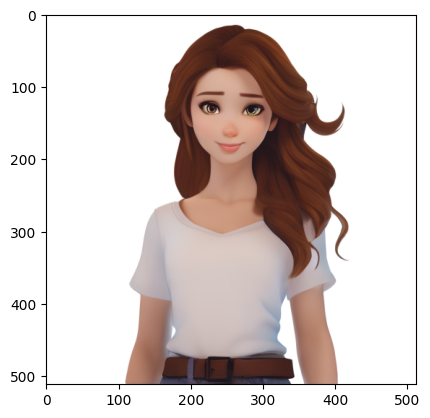

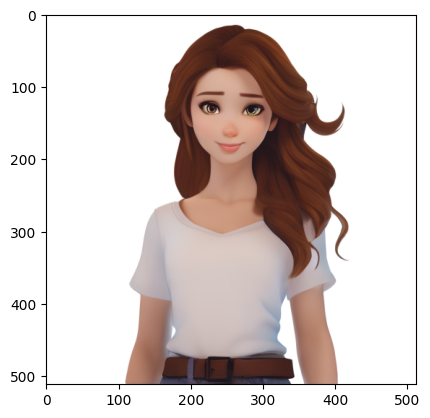

In [21]:
centered_img = recenter_image(image)
delight_img = delight_image(recenter_image(centered_img))
print(delight_img)
img_array = np.array(delight_img)
plt.imshow(img_array)
plt.show()
new_img = delight_image(delight_img)

img_array = np.array(delight_img)
plt.imshow(img_array)
plt.show()